In [1]:
import os
import json
import shutil


In [ ]:
%cd /content
!rm -rf NFTM

In [ ]:
REPO_URL = "https://github.com/stef4k/NFTM.git"
!git clone $REPO_URL
%cd NFTM

In [ ]:
!pip install lpips torchmetrics pytorch-msssim tqdm pandas torch-fidelity

In [ ]:
from google.colab import files
for i in range(2, 23, 4):
  for j in range(2, 23, 4):
    run_name = f"train_Kt{i}_Ke{j}"
    save_dir = f"runs/{run_name}"
    !python3 image_inpainting.py --epochs 3 --batch_size 128 --K_train {i} --K_eval {j} --beta_start 0.28 --beta_max 0.6 --beta_anneal 0.03 --beta_eval_bonus 0.05 --corr_clip 0.1 --tv_weight 0.01 --pmin 0.25 --pmax 0.5 --block_prob 0.5 --noise_std 0.3 --width 48 --save_metrics --guard_in_train --save_dir {save_dir}
    zip_name = f"/content/{run_name}.zip"
    !zip -r {zip_name} /content/NFTM/{save_dir}
    files.download(zip_name)

In [ ]:
base_output = "output"
import shutil
import os
for i in range(2, 23, 4):
    for j in range(2, 23, 4):
        run_name = f"train_Kt{i}_Ke{j}"
        save_dir = os.path.join(base_output, run_name)
        os.makedirs(save_dir, exist_ok=True)
        !python3 image_inpainting.py --epochs 3 --batch_size 128 --K_train {i} --K_eval {j} --beta_start 0.28 --beta_max 0.6 --beta_anneal 0.03 --beta_eval_bonus 0.05 --corr_clip 0.1 --tv_weight 0.01 --pmin 0.25 --pmax 0.5 --block_prob 0.5 --noise_std 0.3 --width 48 --save_metrics --guard_in_train --save_dir {save_dir}
        zip_base = os.path.join(base_output, run_name)
        shutil.make_archive(zip_base, "zip", save_dir)

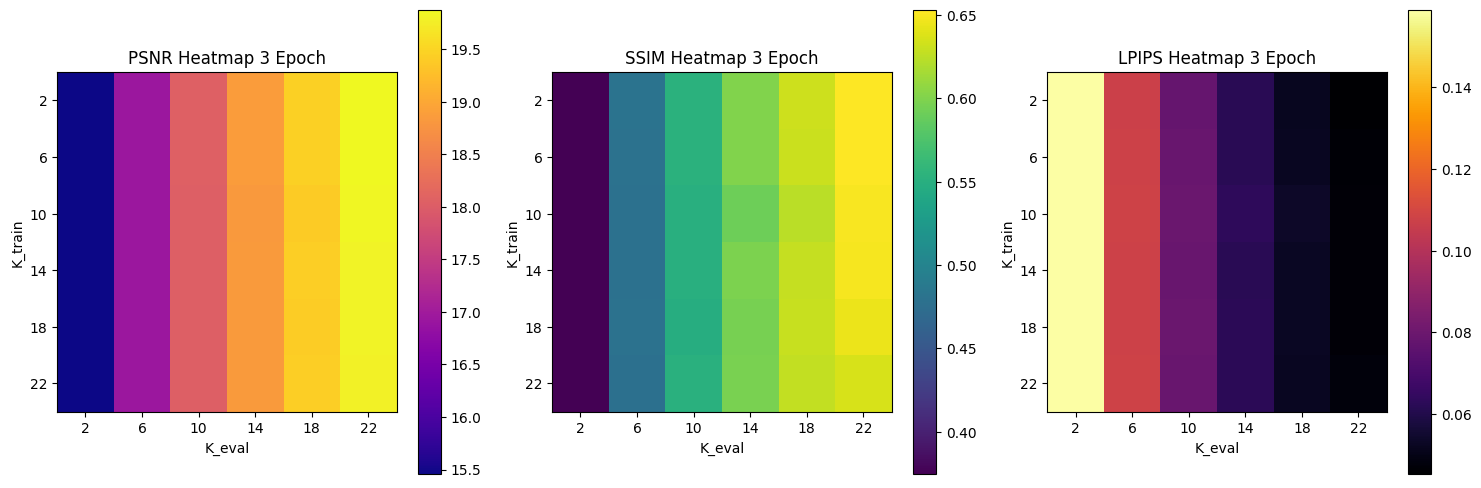

Best combo: 19.869143763674966 K_train2 K_eval22


In [ ]:
### save all the result in a directory called destination2
import os
import json
import matplotlib.pyplot as plt
import numpy as np

psnr = [[0 for _ in range(6)] for _ in range(6)]
ssim = [[0 for _ in range(6)] for _ in range(6)]
lpips = [[0 for _ in range(6)] for _ in range(6)]

base_dir = os.getcwd()
currseries = []
i_vals = list(range(2, 23, 4))
j_vals = list(range(2, 23, 4))
massimo = 0
indice_massimo = 0,0
for i_idx, i in enumerate(i_vals):
    for j_idx, j in enumerate(j_vals):
        json_path = os.path.join(base_dir, "destination2", f"train_Kt{i}_Ke{j}", "metrics.json")
        ##print(json_path)
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)
                psnr[i_idx][j_idx] = data["curve"][-1]
                if data["curve"][-1] > massimo:
                    ##print("entrato")
                    massimo = data["curve"][-1]
                    indice_massimo = i, j

                ##print("Number of NFTM steps",len(data["curve"]))
                ssim[i_idx][j_idx] = data["curve_ssim"][-1]
                lpips[i_idx][j_idx] = data["curve_lpips"][-1]
        except FileNotFoundError:
            print(f"file not found: {json_path}")
        except Exception as e:
            print(f"error in {json_path}: {e}")
psnr = np.array(psnr)
ssim = np.array(ssim)
lpips = np.array(lpips)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(psnr, cmap="plasma", interpolation="nearest")
axes[0].set_title("PSNR Heatmap 3 Epoch")

axes[0].set_xticks(range(len(j_vals)))
axes[0].set_xticklabels(j_vals)
axes[0].set_yticks(range(len(i_vals)))
axes[0].set_yticklabels(i_vals)
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(ssim, cmap="viridis", interpolation="nearest")
axes[1].set_title("SSIM Heatmap 3 Epoch")
axes[1].set_xticks(range(len(j_vals)))
axes[1].set_xticklabels(j_vals)
axes[1].set_yticks(range(len(i_vals)))
axes[1].set_yticklabels(i_vals)
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(lpips, cmap="inferno", interpolation="nearest")
axes[2].set_title("LPIPS Heatmap 3 Epoch")
axes[2].set_xticks(range(len(j_vals)))
axes[2].set_xticklabels(j_vals)
axes[2].set_yticks(range(len(i_vals)))
axes[2].set_yticklabels(i_vals)
plt.colorbar(im3, ax=axes[2])

axes[0].set_ylabel("K_train")
axes[0].set_xlabel("K_eval")

axes[1].set_ylabel("K_train")
axes[1].set_xlabel("K_eval")

axes[2].set_ylabel("K_train")
axes[2].set_xlabel("K_eval")
plt.tight_layout()
plt.show()

i = indice_massimo[0]
j = indice_massimo[1]

print(f"Best combo:",massimo,f"K_train{i}", f"K_eval{j}" )


        

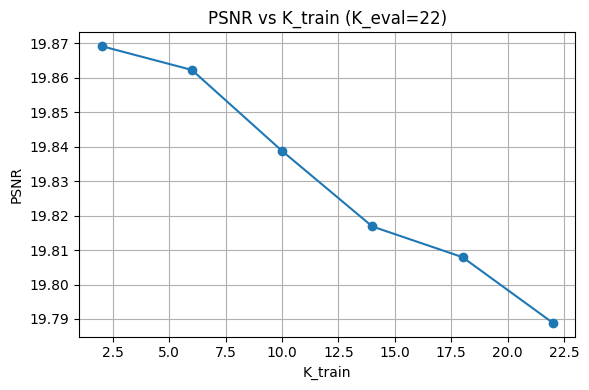

In [12]:
# ---- Keep only K_eval = 22: save values + plot PSNR vs K_train ----
import csv

j_target = 22
try:
    j_idx = j_vals.index(j_target)
except ValueError:
    raise ValueError(f"K_eval={j_target} is not in j_vals={j_vals}")

ktrain_list = i_vals
psnr_col = psnr[:, j_idx]
ssim_col = ssim[:, j_idx]
lpips_col = lpips[:, j_idx]

# Save only the rows with K_eval = 22
out_csv = os.path.join(base_dir, f"metrics_keval_{j_target}.csv")
with open(out_csv, "w", newline="", encoding="utf-8") as fp:
    w = csv.writer(fp)
    w.writerow(["K_train", "PSNR", "SSIM", "LPIPS"])
    for kt, p, s, l in zip(ktrain_list, psnr_col, ssim_col, lpips_col):
        w.writerow([kt, float(p), float(s), float(l)])

# Line plot: PSNR vs K_train (with K_eval fixed to 22)
plt.figure(figsize=(6, 4))
plt.plot(ktrain_list, psnr_col, marker="o")
plt.title(f"PSNR vs K_train (K_eval={j_target})")
plt.xlabel("K_train")
plt.ylabel("PSNR")
plt.grid(True)
plt.tight_layout()
plot_path = os.path.join(base_dir, f"psnr_vs_ktrain_keval{j_target}.png")
plt.savefig(plot_path)
plt.show()
plt.close()


